In [1]:
import earthaccess
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# Download files

In [2]:
# make sure to login first before downloading files, otherwise get none
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 08/18/2023
Using .netrc file for EDL


In [18]:
# First approach, search only
results = earthaccess.search_data(
    short_name='OSCAR_L4_OC_FINAL_V2.0',
    cloud_hosted=True,
    bounding_box = (60, 5, 80, 25),
    temporal=("2007-01", "2020-12")
)

Granules found: 5084



KeyboardInterrupt



In [3]:
# Second approach

def download_granules_by_year(year):
    granules = []
    count = 1
    date = pd.date_range(f'{year}-01-01', f'{year+1}-02-01', freq='M')
    for i in range(len(date)-1):
        # get all days
        granule = earthaccess.granule_query().short_name("OSCAR_L4_OC_FINAL_V2.0").temporal(f'{date[i].year}-{date[i].month}',
                                                                                            f'{date[i+1].year}-{date[i+1].month}').get(32)
        print(count, end=" ")
        count +=1
        granules.extend(granule)
    
    # from precomputed calculations, the bounding box indices are:
    lat1, lat2, lon1, lon2 = 168, 408, 311, 487
    print(len(granules))
    files = earthaccess.download(granules, 'surface_currents/')
    
    # combine files
    data = xr.open_mfdataset(f'surface_currents/oscar_currents_final_{year}*.nc').isel(latitude=slice(lat1, lat2+1), longitude=slice(lon1, lon2+1))
    data.to_netcdf(f'surface_currents/combined/{year}-processed-new.nc')
    
    # delete file chunks by running 
    # rm -rf surface_currents/oscar_currents_final_[YEAR]*.nc in command line
    

In [11]:
for i in list(range(2000, 2021)):
    download_granules_by_year(i)

1 2 3 4 5 6 7 8 9 10 11 12 377
 Getting 377 granules, approx download size: 0.0 GB


SUBMITTING | :   0%|          | 0/377 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/377 [00:00<?, ?it/s]

File oscar_currents_final_20201201.nc already downloaded


COLLECTING | :   0%|          | 0/377 [00:00<?, ?it/s]

In [6]:
year=2000
granule = earthaccess.granule_query().short_name("OSCAR_L4_OC_FINAL_V2.0").temporal('2000-01','2000-02').get(32)

files = earthaccess.download(granule, 'surface_currents/')

 Getting 32 granules, approx download size: 0.0 GB


SUBMITTING | :   0%|          | 0/32 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/32 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/32 [00:00<?, ?it/s]

In [21]:
file0101 = xr.open_dataset('surface_currents/oscar_currents_final_20000101.nc')

In [13]:
file0101 = file0101.rename({'latitude': 'lat', 'longitude':'lon'})

In [37]:
xr.open_dataset('earthdata/OSCAR_L4_OC_FINAL_V2.0/2000_processed.nc')

<xarray.Dataset>
Dimensions:  (latitude: 177, longitude: 241, time: 367)
Coordinates:
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
  * time     (time) object 2000-01-01 00:00:00 ... 2001-01-01 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

# Examine files

In [3]:
xr.open_mfdataset('surface_currents/oscar_currents_final_200001*.nc')

OSError: no files to open

In [28]:
f1 = xr.open_dataset('surface_currents/oscar_currents_final_20000102.nc')

In [43]:
xr.open_dataset('surface_currents/oscar_currents_final_20071019.nc')

OSError: [Errno -101] NetCDF: HDF error: '/home/jovyan/surface_currents/oscar_currents_final_20071019.nc'

In [9]:
f1 = f1.transpose('time', 'latitude', 'longitude')

In [30]:
lat_vals = f1.lat.values
lon_vals = f1.lon.values

In [31]:
lat1 = np.where(lat_vals==-12)[0][0]
lat2 = np.where(lat_vals==32)[0][0]
lon1 = np.where(lon_vals==42)[0][0]
lon2 = np.where(lon_vals==102)[0][0]

In [32]:
print(lat1, lat2, lon1, lon2)

311 487 168 408


In [33]:
f1['ug'].sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1))

<xarray.DataArray 'ug' (time: 1, longitude: 241, latitude: 177)>
array([[[-0.054644, -0.125824, ...,       nan,       nan],
        [ 0.021654, -0.078195, ...,       nan,       nan],
        ...,
        [ 0.119461,  0.158764, ...,       nan,       nan],
        [ 0.15405 ,  0.182653, ...,       nan,       nan]]])
Coordinates:
    lat      (latitude) float64 -12.0 -11.75 -11.5 -11.25 ... 31.5 31.75 32.0
    lon      (longitude) float64 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time     (time) object 2000-01-02 00:00:00
Dimensions without coordinates: longitude, latitude
Attributes:
    long_name:      zonal geostrophic surface current
    standard_name:  geostrophic_eastward_sea_water_velocity
    units:          m s-1
    valid_min:      -3.0
    valid_max:      3.0
    depth:          15m
    comment:        Geostrophic velocities calculated from absolute dynamic t...
    source:         SSH source: CMEMS SSALTO/DUACS SEALEVEL_GLO_PHY_L4_MY_008...

In [59]:
granules[0].data_links()[0].split('/')[-1]

'oscar_currents_final_20000101.nc'

In [3]:
y = xr.open_dataset('surface_currents/combined/2019-processed.nc')

In [4]:
y

<xarray.Dataset>
Dimensions:  (latitude: 81, longitude: 81, time: 365)
Coordinates:
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
  * time     (time) object 2019-01-01 00:00:00 ... 2019-12-31 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2019-01-01T00:00:00
    time_coverage_end:          2019-01-01T23:59:59
    date_created:               2022-01-14

In [9]:
y.sel(latitude=slice(5, 10), longitude=slice(65, 70))

<xarray.Dataset>
Dimensions:  (latitude: 5, longitude: 5, time: 365)
Coordinates:
    lat      (latitude) float64 6.25 6.5 6.75 7.0 7.25
    lon      (longitude) float64 76.25 76.5 76.75 77.0 77.25
  * time     (time) object 2019-01-01 00:00:00 ... 2019-12-31 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, longitude, latitude) float64 ...
    v        (time, longitude, latitude) float64 ...
    ug       (time, longitude, latitude) float64 ...
    vg       (time, longitude, latitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2019-01-01T00:00:00
    time_coverage_end:          2019-01-01T23:59:59
    date_created:               2022-01-14

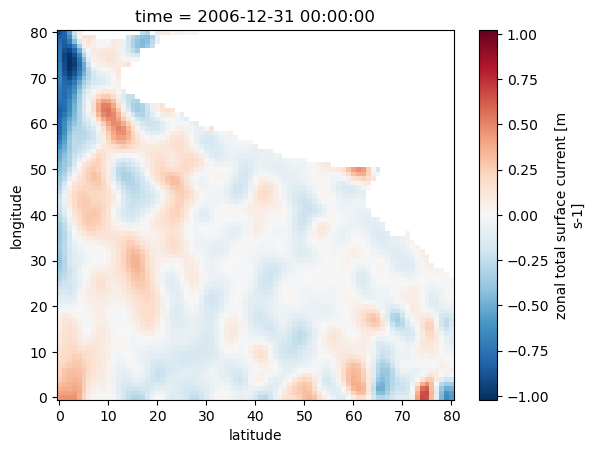

In [17]:
y['u'].isel(time=-1).plot.imshow()

# Plotting ranges

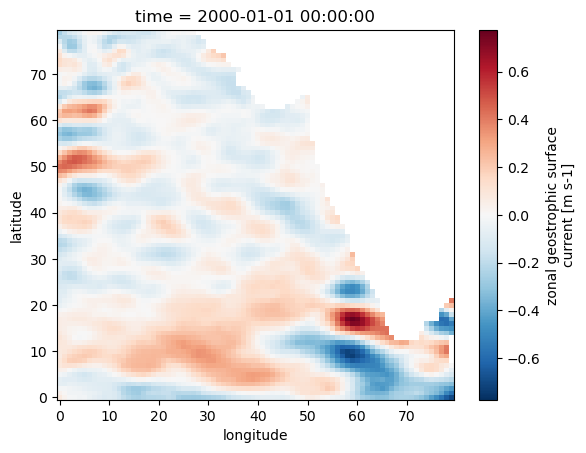

In [12]:
p = f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2),latitude=slice(lat1, lat2)).plot.imshow()

In [90]:
t = p.figure

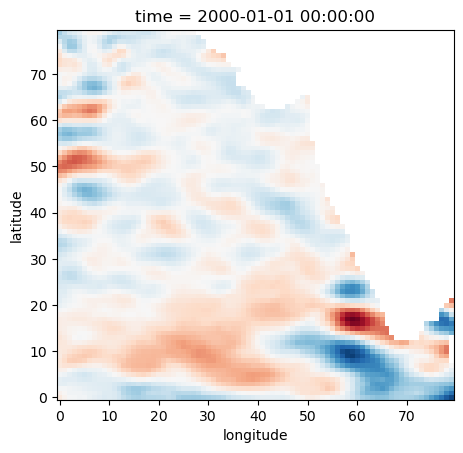

In [91]:
t

In [100]:
t1 = t.axes[0]

In [114]:
t1.axis('off')
t1.set_title('')

Text(0.5, 1.0, '')

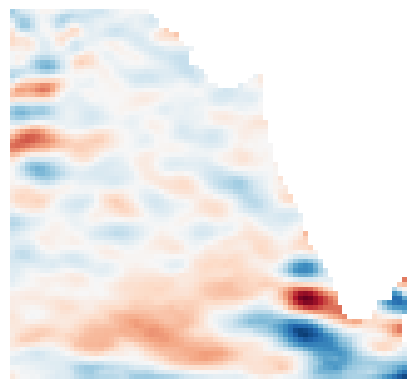

In [115]:
t

In [93]:
t.savefig('2.png')

In [94]:
plt.savefig('2p.png')

<Figure size 640x480 with 0 Axes>

In [49]:
t.axes[1]

<Axes: label='<colorbar>', ylabel='zonal geostrophic surface\ncurrent [m s-1]'>

In [15]:
f1['vg'].sel(lat=f1.lat.to_index().get_indexer())

TypeError: get_indexer() missing 1 required positional argument: 'target'

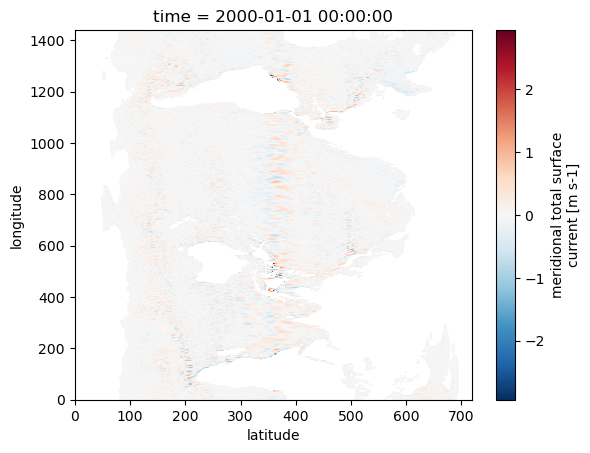

In [12]:
f1['v'].isel(time=0).plot.imshow()

In [111]:
f1

<xarray.Dataset>
Dimensions:  (latitude: 719, longitude: 1440, time: 1)
Coordinates:
    lat      (latitude) float64 -89.75 -89.5 -89.25 -89.0 ... 89.25 89.5 89.75
    lon      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time     (time) object 2000-01-01 00:00:00
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 ...
    v        (time, latitude, longitude) float64 ...
    ug       (time, latitude, longitude) float64 ...
    vg       (time, latitude, longitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

# Combine files

In [2]:
# run this line before plotting!
combined  = xr.open_mfdataset('surface_currents/combined/*.nc').transpose('time', 'latitude', 'longitude')

In [3]:
combined['time'] = combined.indexes['time'].to_datetimeindex()

/tmp/ipykernel_41/3373087629.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  combined['time'] = combined.indexes['time'].to_datetimeindex()


In [4]:
combined

<xarray.Dataset>
Dimensions:  (latitude: 81, longitude: 81, time: 7671)
Coordinates:
    lat      (latitude) float64 dask.array<chunksize=(81,), meta=np.ndarray>
    lon      (longitude) float64 dask.array<chunksize=(81,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    v        (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    ug       (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
    vg       (time, latitude, longitude) float64 dask.array<chunksize=(366, 81, 81), meta=np.ndarray>
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

In [9]:
# make sure that all days are covered
all_days = np.array([s.to_datetime64() for s in pd.date_range('2000/1/1', '2020/12/31')])

#print out days that are not in the dataset, should be none
np.setdiff1d(all_days, combined.time.values)

array([], dtype='datetime64[ns]')

In [5]:
# this does not work
combined_rechunk = xr.unify_chunks(combined)

In [13]:
# unify all chunks over the time dimension
combined.chunk({'time': all_days.shape[0]}).to_zarr('surface_currents/surface_currents.zarr')

# Masking

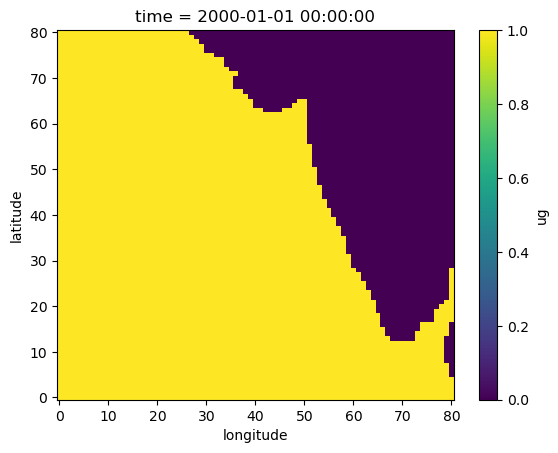

In [25]:
f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().plot.imshow()

In [26]:
f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().to_dataframe()

lat    lon                 time     ug
latitude longitude                                         
0        0           5.0  60.00  2000-01-01 00:00:00   True
         1           5.0  60.25  2000-01-01 00:00:00   True
         2           5.0  60.50  2000-01-01 00:00:00   True
         3           5.0  60.75  2000-01-01 00:00:00   True
         4           5.0  61.00  2000-01-01 00:00:00   True
...                  ...    ...                  ...    ...
80       76         25.0  79.00  2000-01-01 00:00:00  False
         77         25.0  79.25  2000-01-01 00:00:00  False
         78         25.0  79.50  2000-01-01 00:00:00  False
         79         25.0  79.75  2000-01-01 00:00:00  False
         80         25.0  80.00  2000-01-01 00:00:00  False

[6561 rows x 4 columns]

In [27]:
p = f1['ug'].isel(time=0).sel(longitude=slice(lon1, lon2+1),latitude=slice(lat1, lat2+1)).notnull().to_dataframe()

In [28]:
mask = p.reset_index().drop(columns=['latitude', 'longitude', 'time'])

In [31]:
m = mask[mask['ug']==True]

In [32]:
m.to_csv('mask.csv')